In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import *

batch_size=128

In [2]:
#Data loading and augmentation
#Try training without random rotation this time
augmentations = transforms.Compose([transforms.RandomHorizontalFlip(),transforms.RandomCrop(32,padding=4),
                                   transforms.ToTensor(),transforms.Normalize((0.0,0.0,0.0),(1.0,1.0,1.0))])
test_tf = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.0,0.0,0.0),(1.0,1.0,1.0))])
trainset = torchvision.datasets.CIFAR10(root='./CIFAR10',train=True,download=True,transform=augmentations)
testset = torchvision.datasets.CIFAR10(root='./CIFAR10',train=False,download=True,transform=test_tf)
trainval = torchvision.datasets.CIFAR10(root='./CIFAR10',train=True,download=True,transform=test_tf)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=4)
testloader = torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False,num_workers=4)
evalloader = torch.utils.data.DataLoader(trainval,batch_size=batch_size,shuffle=False,num_workers=4)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class ID_Block(nn.Module):
    def __init__(self,channels):
        super(ID_Block,self).__init__()
        self.conv1 = nn.Conv2d(channels,channels,3,padding=1,bias=False) #Bias terms are added by the batchnorm layer
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels,channels,3,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(channels)
    
    def forward(self,x):
        out = self.conv1(x)
        out = F.relu(self.bn1(out))
        out = self.conv2(out)
        out = self.bn2(out)
        out += x
        out = F.relu(out)
        return out
    
class Conv_Block(nn.Module):
    def __init__(self,inchannels,outchannels):
        super(Conv_Block,self).__init__()
        self.conv1 = nn.Conv2d(inchannels,outchannels,3,stride=2,padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(outchannels)
        self.conv2 = nn.Conv2d(outchannels,outchannels,3,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(outchannels)
        self.conv_residual = nn.Conv2d(inchannels,outchannels,2,stride=2)
        self.bn_residual = nn.BatchNorm2d(outchannels)

    def forward(self,x):
        residual = self.conv_residual(x)
        residual = self.bn_residual(residual)
        out = self.conv1(x)
        out = F.relu(self.bn1(out))
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self,resblocks):
        super(ResNet,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.resblocks = resblocks
        self.global_avg_pool = nn.AvgPool2d(8,stride=1)
        self.fc = nn.Linear(64,10)
                
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu')
            elif isinstance(m,nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
    
    def forward(self,x):
        out = self.conv1(x)
        out = F.relu(self.bn1(out))
        out = self.resblocks(out)
        out = self.global_avg_pool(out)
        out = out.view(-1,64)
        out = self.fc(out)
        return out

In [4]:
resblocks = nn.Sequential(ID_Block(16),
                         ID_Block(16),
                         ID_Block(16),
                         ID_Block(16),
                         ID_Block(16),
                         ID_Block(16),
                         ID_Block(16),
                         Conv_Block(16,32),
                         ID_Block(32),
                         ID_Block(32),
                         ID_Block(32),
                         ID_Block(32),
                         ID_Block(32),
                         ID_Block(32),
                         ID_Block(32),
                         Conv_Block(32,64),
                         ID_Block(64),
                         ID_Block(64),
                         ID_Block(64),
                         ID_Block(64),
                         ID_Block(64),
                         ID_Block(64),
                         ID_Block(64))
resnet = ResNet(resblocks)
device = torch.device('cuda')
iters = 0
losses = []
trains = []
evals = []
resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(),lr=0.1,momentum=0.9,weight_decay=0.0001) #See https://arxiv.org/pdf/1705.08292.pdf
scheduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones=[32000,48000])
#optimizer = optim.Adam(resnet.parameters(),weight_decay=0.0001) 

In [5]:
def load_model(path):
    checkpoint = torch.load(self.checkpoints)
    iters = checkpoint['iters']
    resnet.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    losses = checkpoint['losses']
    trains = checkpoint['trains']
    evals = checkpoint['evals']

def save_model(path):
    torch.save({
        'iters' : iters,
        'state_dict' : resnet.state_dict(),
        'optimizer' : optimizer.state_dict(),
        'losses' : losses,
        'trains' : trains,
        'evals' : evals
    },path)
    
def check_accuracy(loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            inputs,labels = data
            inputs,labels = inputs.to(device),labels.to(device)
            outputs = resnet(inputs)
            _,predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return (correct/total)

In [6]:
#load_model('RESNET.model')

In [7]:
i = 0
epochs = 0
running_loss = 0
running_val_loss = 0
resnet.train()
while iters < 64000:
    epochs += 1
    i = 0
    for i,data in tqdm(enumerate(trainloader,1)):
        inputs,labels = data
        inputs,labels = inputs.to(device),labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        if i%100==0:
            print('[Epoch %d,Minibatch %d] Training Loss : %.3f' % (epochs,i,running_loss/100))
            losses.append(running_loss)
            running_loss = 0
            running_val_loss = 0
        iters += 1
    save_model('RESNET.model')
    resnet.eval()
    trainaccuracy = check_accuracy(evalloader)
    evalaccuracy = check_accuracy(testloader)
    resnet.train()
    print('[Epoch %d] : Training Accuracy : %.3f Test Accuracy %.3f' % (epochs,trainaccuracy,evalaccuracy))
    trains.append(trainaccuracy)
    evals.append(evalaccuracy)

print("TRAINING IS NOW COMPLETE")

101it [00:14,  7.09it/s]

[Epoch 1,Minibatch 100] Training Loss : 2.179


201it [00:28,  7.14it/s]

[Epoch 1,Minibatch 200] Training Loss : 1.875


301it [00:42,  7.14it/s]

[Epoch 1,Minibatch 300] Training Loss : 1.739


391it [00:54,  7.14it/s]


[Epoch 1] : Training Accuracy : 0.354 Test Accuracy 0.362


101it [00:14,  7.00it/s]

[Epoch 2,Minibatch 100] Training Loss : 3.033


201it [00:28,  7.01it/s]

[Epoch 2,Minibatch 200] Training Loss : 1.401


301it [00:42,  7.04it/s]

[Epoch 2,Minibatch 300] Training Loss : 1.304


391it [00:55,  7.03it/s]


[Epoch 2] : Training Accuracy : 0.566 Test Accuracy 0.555


101it [00:14,  7.09it/s]

[Epoch 3,Minibatch 100] Training Loss : 2.179


201it [00:28,  7.10it/s]

[Epoch 3,Minibatch 200] Training Loss : 1.008


301it [00:42,  7.09it/s]

[Epoch 3,Minibatch 300] Training Loss : 0.969


391it [00:55,  7.08it/s]


[Epoch 3] : Training Accuracy : 0.597 Test Accuracy 0.591


101it [00:14,  7.10it/s]

[Epoch 4,Minibatch 100] Training Loss : 1.675


201it [00:28,  7.11it/s]

[Epoch 4,Minibatch 200] Training Loss : 0.812


301it [00:42,  7.10it/s]

[Epoch 4,Minibatch 300] Training Loss : 0.776


391it [00:55,  7.08it/s]


[Epoch 4] : Training Accuracy : 0.744 Test Accuracy 0.731


101it [00:14,  6.99it/s]

[Epoch 5,Minibatch 100] Training Loss : 1.360


201it [00:28,  7.00it/s]

[Epoch 5,Minibatch 200] Training Loss : 0.708


301it [00:42,  7.01it/s]

[Epoch 5,Minibatch 300] Training Loss : 0.661


391it [00:55,  7.03it/s]


[Epoch 5] : Training Accuracy : 0.777 Test Accuracy 0.759


101it [00:14,  7.02it/s]

[Epoch 6,Minibatch 100] Training Loss : 1.206


201it [00:28,  7.01it/s]

[Epoch 6,Minibatch 200] Training Loss : 0.598


301it [00:42,  7.02it/s]

[Epoch 6,Minibatch 300] Training Loss : 0.607


391it [00:55,  7.03it/s]


[Epoch 6] : Training Accuracy : 0.776 Test Accuracy 0.757


101it [00:14,  6.96it/s]

[Epoch 7,Minibatch 100] Training Loss : 1.097


201it [00:28,  7.03it/s]

[Epoch 7,Minibatch 200] Training Loss : 0.560


301it [00:42,  7.04it/s]

[Epoch 7,Minibatch 300] Training Loss : 0.560


391it [00:55,  7.06it/s]


[Epoch 7] : Training Accuracy : 0.794 Test Accuracy 0.774


101it [00:14,  7.02it/s]

[Epoch 8,Minibatch 100] Training Loss : 0.987


201it [00:28,  7.03it/s]

[Epoch 8,Minibatch 200] Training Loss : 0.520


301it [00:42,  7.03it/s]

[Epoch 8,Minibatch 300] Training Loss : 0.520


391it [00:55,  7.03it/s]


[Epoch 8] : Training Accuracy : 0.824 Test Accuracy 0.800


101it [00:14,  6.94it/s]

[Epoch 9,Minibatch 100] Training Loss : 0.931


201it [00:28,  6.94it/s]

[Epoch 9,Minibatch 200] Training Loss : 0.474


301it [00:43,  6.96it/s]

[Epoch 9,Minibatch 300] Training Loss : 0.476


391it [00:56,  6.93it/s]


[Epoch 9] : Training Accuracy : 0.834 Test Accuracy 0.808


101it [00:14,  6.99it/s]

[Epoch 10,Minibatch 100] Training Loss : 0.870


201it [00:28,  6.95it/s]

[Epoch 10,Minibatch 200] Training Loss : 0.465


301it [00:44,  6.78it/s]

[Epoch 10,Minibatch 300] Training Loss : 0.461


391it [00:57,  6.77it/s]


[Epoch 10] : Training Accuracy : 0.843 Test Accuracy 0.818


101it [00:14,  6.86it/s]

[Epoch 11,Minibatch 100] Training Loss : 0.828


201it [00:29,  6.89it/s]

[Epoch 11,Minibatch 200] Training Loss : 0.412


301it [00:43,  6.89it/s]

[Epoch 11,Minibatch 300] Training Loss : 0.437


391it [00:56,  6.88it/s]


[Epoch 11] : Training Accuracy : 0.825 Test Accuracy 0.798


101it [00:15,  6.52it/s]

[Epoch 12,Minibatch 100] Training Loss : 0.791


201it [00:31,  6.44it/s]

[Epoch 12,Minibatch 200] Training Loss : 0.415


301it [00:46,  6.48it/s]

[Epoch 12,Minibatch 300] Training Loss : 0.404


391it [01:00,  6.48it/s]


[Epoch 12] : Training Accuracy : 0.854 Test Accuracy 0.824


101it [00:15,  6.52it/s]

[Epoch 13,Minibatch 100] Training Loss : 0.761


201it [00:31,  6.35it/s]

[Epoch 13,Minibatch 200] Training Loss : 0.386


301it [00:46,  6.44it/s]

[Epoch 13,Minibatch 300] Training Loss : 0.388


391it [00:59,  6.52it/s]


[Epoch 13] : Training Accuracy : 0.865 Test Accuracy 0.833


101it [00:15,  6.50it/s]

[Epoch 14,Minibatch 100] Training Loss : 0.713


201it [00:30,  6.60it/s]

[Epoch 14,Minibatch 200] Training Loss : 0.373


301it [00:45,  6.64it/s]

[Epoch 14,Minibatch 300] Training Loss : 0.376


391it [00:58,  6.65it/s]


[Epoch 14] : Training Accuracy : 0.868 Test Accuracy 0.836


101it [00:16,  6.10it/s]

[Epoch 15,Minibatch 100] Training Loss : 0.669


201it [00:33,  6.01it/s]

[Epoch 15,Minibatch 200] Training Loss : 0.368


301it [00:49,  6.10it/s]

[Epoch 15,Minibatch 300] Training Loss : 0.342


391it [01:05,  6.01it/s]


[Epoch 15] : Training Accuracy : 0.884 Test Accuracy 0.848


101it [00:15,  6.65it/s]

[Epoch 16,Minibatch 100] Training Loss : 0.666


201it [00:30,  6.49it/s]

[Epoch 16,Minibatch 200] Training Loss : 0.334


301it [00:48,  6.21it/s]

[Epoch 16,Minibatch 300] Training Loss : 0.363


391it [01:02,  6.29it/s]


[Epoch 16] : Training Accuracy : 0.760 Test Accuracy 0.728


101it [00:15,  6.67it/s]

[Epoch 17,Minibatch 100] Training Loss : 0.629


201it [00:30,  6.60it/s]

[Epoch 17,Minibatch 200] Training Loss : 0.330


301it [00:45,  6.58it/s]

[Epoch 17,Minibatch 300] Training Loss : 0.351


391it [00:59,  6.57it/s]


[Epoch 17] : Training Accuracy : 0.845 Test Accuracy 0.809


101it [00:15,  6.55it/s]

[Epoch 18,Minibatch 100] Training Loss : 0.633


201it [00:31,  6.40it/s]

[Epoch 18,Minibatch 200] Training Loss : 0.319


301it [00:46,  6.42it/s]

[Epoch 18,Minibatch 300] Training Loss : 0.331


391it [01:00,  6.45it/s]


[Epoch 18] : Training Accuracy : 0.880 Test Accuracy 0.834


101it [00:15,  6.70it/s]

[Epoch 19,Minibatch 100] Training Loss : 0.613


201it [00:29,  6.74it/s]

[Epoch 19,Minibatch 200] Training Loss : 0.304


301it [00:44,  6.73it/s]

[Epoch 19,Minibatch 300] Training Loss : 0.331


391it [00:58,  6.73it/s]


[Epoch 19] : Training Accuracy : 0.885 Test Accuracy 0.847


101it [00:15,  6.61it/s]

[Epoch 20,Minibatch 100] Training Loss : 0.567


201it [00:30,  6.49it/s]

[Epoch 20,Minibatch 200] Training Loss : 0.306


301it [00:46,  6.44it/s]

[Epoch 20,Minibatch 300] Training Loss : 0.318


391it [01:00,  6.47it/s]


[Epoch 20] : Training Accuracy : 0.876 Test Accuracy 0.826


101it [00:14,  6.88it/s]

[Epoch 21,Minibatch 100] Training Loss : 0.567


201it [00:29,  6.91it/s]

[Epoch 21,Minibatch 200] Training Loss : 0.289


301it [00:43,  6.93it/s]

[Epoch 21,Minibatch 300] Training Loss : 0.314


391it [00:56,  6.95it/s]


[Epoch 21] : Training Accuracy : 0.864 Test Accuracy 0.823


101it [00:14,  7.05it/s]

[Epoch 22,Minibatch 100] Training Loss : 0.564


201it [00:28,  7.02it/s]

[Epoch 22,Minibatch 200] Training Loss : 0.285


301it [00:43,  6.97it/s]

[Epoch 22,Minibatch 300] Training Loss : 0.295


391it [00:56,  6.88it/s]


[Epoch 22] : Training Accuracy : 0.889 Test Accuracy 0.849


101it [00:14,  6.77it/s]

[Epoch 23,Minibatch 100] Training Loss : 0.551


201it [00:29,  6.78it/s]

[Epoch 23,Minibatch 200] Training Loss : 0.263


301it [00:44,  6.78it/s]

[Epoch 23,Minibatch 300] Training Loss : 0.291


391it [00:57,  6.84it/s]


[Epoch 23] : Training Accuracy : 0.898 Test Accuracy 0.856


101it [00:14,  6.92it/s]

[Epoch 24,Minibatch 100] Training Loss : 0.539


201it [00:29,  6.84it/s]

[Epoch 24,Minibatch 200] Training Loss : 0.283


301it [00:43,  6.87it/s]

[Epoch 24,Minibatch 300] Training Loss : 0.277


391it [00:56,  6.89it/s]


[Epoch 24] : Training Accuracy : 0.902 Test Accuracy 0.857


101it [00:14,  6.75it/s]

[Epoch 25,Minibatch 100] Training Loss : 0.515


201it [00:29,  6.90it/s]

[Epoch 25,Minibatch 200] Training Loss : 0.278


301it [00:43,  6.93it/s]

[Epoch 25,Minibatch 300] Training Loss : 0.275


391it [00:56,  6.95it/s]


[Epoch 25] : Training Accuracy : 0.907 Test Accuracy 0.861


101it [00:14,  7.03it/s]

[Epoch 26,Minibatch 100] Training Loss : 0.511


201it [00:28,  7.03it/s]

[Epoch 26,Minibatch 200] Training Loss : 0.257


301it [00:42,  7.04it/s]

[Epoch 26,Minibatch 300] Training Loss : 0.266


391it [00:55,  7.03it/s]


[Epoch 26] : Training Accuracy : 0.887 Test Accuracy 0.846


101it [00:14,  6.93it/s]

[Epoch 27,Minibatch 100] Training Loss : 0.487


201it [00:28,  6.99it/s]

[Epoch 27,Minibatch 200] Training Loss : 0.256


301it [00:42,  7.01it/s]

[Epoch 27,Minibatch 300] Training Loss : 0.262


391it [00:55,  7.03it/s]


[Epoch 27] : Training Accuracy : 0.891 Test Accuracy 0.843


101it [00:14,  6.96it/s]

[Epoch 28,Minibatch 100] Training Loss : 0.472


201it [00:28,  6.98it/s]

[Epoch 28,Minibatch 200] Training Loss : 0.248


301it [00:43,  6.95it/s]

[Epoch 28,Minibatch 300] Training Loss : 0.260


391it [00:56,  6.98it/s]


[Epoch 28] : Training Accuracy : 0.898 Test Accuracy 0.854


101it [00:14,  7.02it/s]

[Epoch 29,Minibatch 100] Training Loss : 0.486


201it [00:28,  7.01it/s]

[Epoch 29,Minibatch 200] Training Loss : 0.249


301it [00:43,  6.99it/s]

[Epoch 29,Minibatch 300] Training Loss : 0.274


391it [00:55,  7.01it/s]


[Epoch 29] : Training Accuracy : 0.913 Test Accuracy 0.869


101it [00:14,  6.86it/s]

[Epoch 30,Minibatch 100] Training Loss : 0.460


201it [00:29,  6.87it/s]

[Epoch 30,Minibatch 200] Training Loss : 0.256


301it [00:43,  6.88it/s]

[Epoch 30,Minibatch 300] Training Loss : 0.252


391it [00:56,  6.90it/s]


[Epoch 30] : Training Accuracy : 0.911 Test Accuracy 0.867


101it [00:14,  6.96it/s]

[Epoch 31,Minibatch 100] Training Loss : 0.463


201it [00:28,  7.02it/s]

[Epoch 31,Minibatch 200] Training Loss : 0.240


301it [00:42,  7.04it/s]

[Epoch 31,Minibatch 300] Training Loss : 0.242


391it [00:55,  7.04it/s]


[Epoch 31] : Training Accuracy : 0.856 Test Accuracy 0.815


101it [00:14,  7.03it/s]

[Epoch 32,Minibatch 100] Training Loss : 0.451


201it [00:28,  7.01it/s]

[Epoch 32,Minibatch 200] Training Loss : 0.223


301it [00:43,  7.00it/s]

[Epoch 32,Minibatch 300] Training Loss : 0.258


391it [00:55,  7.02it/s]


[Epoch 32] : Training Accuracy : 0.929 Test Accuracy 0.882


101it [00:14,  6.96it/s]

[Epoch 33,Minibatch 100] Training Loss : 0.445


201it [00:28,  7.01it/s]

[Epoch 33,Minibatch 200] Training Loss : 0.213


301it [00:42,  7.03it/s]

[Epoch 33,Minibatch 300] Training Loss : 0.239


391it [00:55,  7.04it/s]


[Epoch 33] : Training Accuracy : 0.896 Test Accuracy 0.854


101it [00:14,  7.05it/s]

[Epoch 34,Minibatch 100] Training Loss : 0.436


201it [00:28,  6.98it/s]

[Epoch 34,Minibatch 200] Training Loss : 0.233


301it [00:42,  7.00it/s]

[Epoch 34,Minibatch 300] Training Loss : 0.233


391it [00:55,  7.01it/s]


[Epoch 34] : Training Accuracy : 0.920 Test Accuracy 0.870


101it [00:14,  6.93it/s]

[Epoch 35,Minibatch 100] Training Loss : 0.439


201it [00:28,  6.97it/s]

[Epoch 35,Minibatch 200] Training Loss : 0.223


301it [00:43,  6.99it/s]

[Epoch 35,Minibatch 300] Training Loss : 0.243


391it [00:55,  7.01it/s]


[Epoch 35] : Training Accuracy : 0.901 Test Accuracy 0.857


101it [00:14,  6.95it/s]

[Epoch 36,Minibatch 100] Training Loss : 0.433


201it [00:28,  6.96it/s]

[Epoch 36,Minibatch 200] Training Loss : 0.217


301it [00:43,  6.96it/s]

[Epoch 36,Minibatch 300] Training Loss : 0.242


391it [00:56,  6.96it/s]


[Epoch 36] : Training Accuracy : 0.907 Test Accuracy 0.862


101it [00:14,  6.95it/s]

[Epoch 37,Minibatch 100] Training Loss : 0.405


201it [00:28,  7.00it/s]

[Epoch 37,Minibatch 200] Training Loss : 0.219


301it [00:42,  7.02it/s]

[Epoch 37,Minibatch 300] Training Loss : 0.227


391it [00:55,  7.03it/s]


[Epoch 37] : Training Accuracy : 0.903 Test Accuracy 0.856


101it [00:14,  7.03it/s]

[Epoch 38,Minibatch 100] Training Loss : 0.408


201it [00:28,  7.05it/s]

[Epoch 38,Minibatch 200] Training Loss : 0.218


301it [00:42,  7.05it/s]

[Epoch 38,Minibatch 300] Training Loss : 0.220


391it [00:55,  7.07it/s]


[Epoch 38] : Training Accuracy : 0.906 Test Accuracy 0.854


101it [00:14,  7.05it/s]

[Epoch 39,Minibatch 100] Training Loss : 0.410


201it [00:28,  7.07it/s]

[Epoch 39,Minibatch 200] Training Loss : 0.213


301it [00:42,  7.06it/s]

[Epoch 39,Minibatch 300] Training Loss : 0.227


391it [00:55,  7.07it/s]


[Epoch 39] : Training Accuracy : 0.912 Test Accuracy 0.867


101it [00:14,  7.03it/s]

[Epoch 40,Minibatch 100] Training Loss : 0.398


201it [00:28,  7.04it/s]

[Epoch 40,Minibatch 200] Training Loss : 0.210


301it [00:42,  7.04it/s]

[Epoch 40,Minibatch 300] Training Loss : 0.218


391it [00:55,  7.05it/s]


[Epoch 40] : Training Accuracy : 0.902 Test Accuracy 0.853


101it [00:14,  7.03it/s]

[Epoch 41,Minibatch 100] Training Loss : 0.402


201it [00:28,  7.04it/s]

[Epoch 41,Minibatch 200] Training Loss : 0.216


301it [00:42,  7.04it/s]

[Epoch 41,Minibatch 300] Training Loss : 0.220


391it [00:55,  7.05it/s]


[Epoch 41] : Training Accuracy : 0.919 Test Accuracy 0.869


101it [00:14,  7.02it/s]

[Epoch 42,Minibatch 100] Training Loss : 0.385


201it [00:28,  7.04it/s]

[Epoch 42,Minibatch 200] Training Loss : 0.201


301it [00:42,  7.03it/s]

[Epoch 42,Minibatch 300] Training Loss : 0.217


391it [00:55,  7.03it/s]


[Epoch 42] : Training Accuracy : 0.872 Test Accuracy 0.823


101it [00:14,  7.04it/s]

[Epoch 43,Minibatch 100] Training Loss : 0.404


201it [00:28,  7.06it/s]

[Epoch 43,Minibatch 200] Training Loss : 0.208


301it [00:42,  7.05it/s]

[Epoch 43,Minibatch 300] Training Loss : 0.207


391it [00:55,  7.06it/s]


[Epoch 43] : Training Accuracy : 0.932 Test Accuracy 0.879


101it [00:14,  7.03it/s]

[Epoch 44,Minibatch 100] Training Loss : 0.392


201it [00:28,  7.04it/s]

[Epoch 44,Minibatch 200] Training Loss : 0.201


301it [00:42,  7.04it/s]

[Epoch 44,Minibatch 300] Training Loss : 0.211


391it [00:55,  7.05it/s]


[Epoch 44] : Training Accuracy : 0.938 Test Accuracy 0.884


101it [00:14,  7.08it/s]

[Epoch 45,Minibatch 100] Training Loss : 0.385


201it [00:28,  7.06it/s]

[Epoch 45,Minibatch 200] Training Loss : 0.199


301it [00:42,  7.04it/s]

[Epoch 45,Minibatch 300] Training Loss : 0.203


391it [00:55,  7.03it/s]


[Epoch 45] : Training Accuracy : 0.876 Test Accuracy 0.827


101it [00:14,  7.01it/s]

[Epoch 46,Minibatch 100] Training Loss : 0.379


201it [00:28,  7.02it/s]

[Epoch 46,Minibatch 200] Training Loss : 0.216


301it [00:42,  7.02it/s]

[Epoch 46,Minibatch 300] Training Loss : 0.204


391it [00:55,  7.02it/s]


[Epoch 46] : Training Accuracy : 0.909 Test Accuracy 0.855


101it [00:14,  6.99it/s]

[Epoch 47,Minibatch 100] Training Loss : 0.362


201it [00:28,  7.00it/s]

[Epoch 47,Minibatch 200] Training Loss : 0.197


301it [00:42,  7.00it/s]

[Epoch 47,Minibatch 300] Training Loss : 0.198


391it [00:55,  7.01it/s]


[Epoch 47] : Training Accuracy : 0.921 Test Accuracy 0.869


101it [00:14,  6.99it/s]

[Epoch 48,Minibatch 100] Training Loss : 0.376


201it [00:28,  7.00it/s]

[Epoch 48,Minibatch 200] Training Loss : 0.189


301it [00:42,  7.00it/s]

[Epoch 48,Minibatch 300] Training Loss : 0.190


391it [00:55,  7.01it/s]


[Epoch 48] : Training Accuracy : 0.900 Test Accuracy 0.849


101it [00:14,  6.98it/s]

[Epoch 49,Minibatch 100] Training Loss : 0.360


201it [00:28,  7.00it/s]

[Epoch 49,Minibatch 200] Training Loss : 0.185


301it [00:43,  6.99it/s]

[Epoch 49,Minibatch 300] Training Loss : 0.210


391it [00:55,  7.00it/s]


[Epoch 49] : Training Accuracy : 0.914 Test Accuracy 0.858


101it [00:14,  7.00it/s]

[Epoch 50,Minibatch 100] Training Loss : 0.358


201it [00:28,  7.01it/s]

[Epoch 50,Minibatch 200] Training Loss : 0.189


301it [00:42,  7.00it/s]

[Epoch 50,Minibatch 300] Training Loss : 0.201


391it [00:55,  7.01it/s]


[Epoch 50] : Training Accuracy : 0.912 Test Accuracy 0.865


101it [00:14,  7.00it/s]

[Epoch 51,Minibatch 100] Training Loss : 0.363


201it [00:28,  7.00it/s]

[Epoch 51,Minibatch 200] Training Loss : 0.191


301it [00:43,  6.99it/s]

[Epoch 51,Minibatch 300] Training Loss : 0.195


391it [00:55,  7.00it/s]


[Epoch 51] : Training Accuracy : 0.925 Test Accuracy 0.872


101it [00:14,  7.01it/s]

[Epoch 52,Minibatch 100] Training Loss : 0.367


201it [00:28,  7.01it/s]

[Epoch 52,Minibatch 200] Training Loss : 0.194


301it [00:42,  7.01it/s]

[Epoch 52,Minibatch 300] Training Loss : 0.191


391it [00:55,  7.02it/s]


[Epoch 52] : Training Accuracy : 0.927 Test Accuracy 0.872


101it [00:14,  7.01it/s]

[Epoch 53,Minibatch 100] Training Loss : 0.362


201it [00:28,  7.02it/s]

[Epoch 53,Minibatch 200] Training Loss : 0.187


301it [00:42,  7.03it/s]

[Epoch 53,Minibatch 300] Training Loss : 0.203


391it [00:55,  7.03it/s]


[Epoch 53] : Training Accuracy : 0.923 Test Accuracy 0.865


101it [00:14,  7.04it/s]

[Epoch 54,Minibatch 100] Training Loss : 0.361


201it [00:28,  7.04it/s]

[Epoch 54,Minibatch 200] Training Loss : 0.180


301it [00:42,  7.03it/s]

[Epoch 54,Minibatch 300] Training Loss : 0.193


391it [00:55,  7.04it/s]


[Epoch 54] : Training Accuracy : 0.922 Test Accuracy 0.875


101it [00:14,  7.03it/s]

[Epoch 55,Minibatch 100] Training Loss : 0.355


201it [00:28,  7.03it/s]

[Epoch 55,Minibatch 200] Training Loss : 0.188


301it [00:42,  7.02it/s]

[Epoch 55,Minibatch 300] Training Loss : 0.198


391it [00:55,  7.03it/s]


[Epoch 55] : Training Accuracy : 0.927 Test Accuracy 0.870


101it [00:14,  7.05it/s]

[Epoch 56,Minibatch 100] Training Loss : 0.331


201it [00:28,  7.03it/s]

[Epoch 56,Minibatch 200] Training Loss : 0.200


301it [00:42,  7.03it/s]

[Epoch 56,Minibatch 300] Training Loss : 0.208


391it [00:55,  7.03it/s]


[Epoch 56] : Training Accuracy : 0.940 Test Accuracy 0.882


101it [00:14,  7.03it/s]

[Epoch 57,Minibatch 100] Training Loss : 0.326


201it [00:28,  7.03it/s]

[Epoch 57,Minibatch 200] Training Loss : 0.185


301it [00:42,  7.03it/s]

[Epoch 57,Minibatch 300] Training Loss : 0.192


391it [00:55,  7.03it/s]


[Epoch 57] : Training Accuracy : 0.937 Test Accuracy 0.880


101it [00:14,  7.03it/s]

[Epoch 58,Minibatch 100] Training Loss : 0.332


201it [00:28,  7.03it/s]

[Epoch 58,Minibatch 200] Training Loss : 0.170


301it [00:42,  7.02it/s]

[Epoch 58,Minibatch 300] Training Loss : 0.191


391it [00:55,  7.03it/s]


[Epoch 58] : Training Accuracy : 0.910 Test Accuracy 0.859


101it [00:14,  7.03it/s]

[Epoch 59,Minibatch 100] Training Loss : 0.353


201it [00:28,  7.03it/s]

[Epoch 59,Minibatch 200] Training Loss : 0.185


301it [00:42,  7.03it/s]

[Epoch 59,Minibatch 300] Training Loss : 0.185


391it [00:55,  7.03it/s]


[Epoch 59] : Training Accuracy : 0.918 Test Accuracy 0.863


101it [00:14,  7.02it/s]

[Epoch 60,Minibatch 100] Training Loss : 0.349


201it [00:28,  7.02it/s]

[Epoch 60,Minibatch 200] Training Loss : 0.176


301it [00:42,  7.02it/s]

[Epoch 60,Minibatch 300] Training Loss : 0.181


391it [00:55,  7.02it/s]


[Epoch 60] : Training Accuracy : 0.926 Test Accuracy 0.871


101it [00:14,  7.04it/s]

[Epoch 61,Minibatch 100] Training Loss : 0.348


201it [00:28,  7.01it/s]

[Epoch 61,Minibatch 200] Training Loss : 0.180


301it [00:43,  6.99it/s]

[Epoch 61,Minibatch 300] Training Loss : 0.188


391it [00:55,  6.99it/s]


[Epoch 61] : Training Accuracy : 0.930 Test Accuracy 0.876


101it [00:14,  6.93it/s]

[Epoch 62,Minibatch 100] Training Loss : 0.350


201it [00:29,  6.93it/s]

[Epoch 62,Minibatch 200] Training Loss : 0.169


301it [00:43,  6.93it/s]

[Epoch 62,Minibatch 300] Training Loss : 0.184


391it [00:56,  6.93it/s]


[Epoch 62] : Training Accuracy : 0.919 Test Accuracy 0.864


101it [00:14,  6.95it/s]

[Epoch 63,Minibatch 100] Training Loss : 0.331


201it [00:28,  6.94it/s]

[Epoch 63,Minibatch 200] Training Loss : 0.167


301it [00:43,  6.94it/s]

[Epoch 63,Minibatch 300] Training Loss : 0.185


391it [00:56,  6.95it/s]


[Epoch 63] : Training Accuracy : 0.919 Test Accuracy 0.866


101it [00:14,  6.97it/s]

[Epoch 64,Minibatch 100] Training Loss : 0.327


201it [00:28,  6.95it/s]

[Epoch 64,Minibatch 200] Training Loss : 0.187


301it [00:43,  6.96it/s]

[Epoch 64,Minibatch 300] Training Loss : 0.195


391it [00:56,  6.95it/s]


[Epoch 64] : Training Accuracy : 0.952 Test Accuracy 0.895


101it [00:14,  6.94it/s]

[Epoch 65,Minibatch 100] Training Loss : 0.327


201it [00:28,  6.95it/s]

[Epoch 65,Minibatch 200] Training Loss : 0.175


301it [00:43,  6.94it/s]

[Epoch 65,Minibatch 300] Training Loss : 0.180


391it [00:56,  6.94it/s]


[Epoch 65] : Training Accuracy : 0.949 Test Accuracy 0.893


101it [00:14,  6.95it/s]

[Epoch 66,Minibatch 100] Training Loss : 0.317


201it [00:28,  6.95it/s]

[Epoch 66,Minibatch 200] Training Loss : 0.168


301it [00:43,  6.95it/s]

[Epoch 66,Minibatch 300] Training Loss : 0.169


391it [00:56,  6.95it/s]


[Epoch 66] : Training Accuracy : 0.927 Test Accuracy 0.874


101it [00:14,  6.94it/s]

[Epoch 67,Minibatch 100] Training Loss : 0.352


201it [00:28,  6.95it/s]

[Epoch 67,Minibatch 200] Training Loss : 0.178


301it [00:43,  6.95it/s]

[Epoch 67,Minibatch 300] Training Loss : 0.177


391it [00:56,  6.95it/s]


[Epoch 67] : Training Accuracy : 0.949 Test Accuracy 0.888


101it [00:14,  6.95it/s]

[Epoch 68,Minibatch 100] Training Loss : 0.328


201it [00:28,  6.94it/s]

[Epoch 68,Minibatch 200] Training Loss : 0.173


301it [00:43,  6.94it/s]

[Epoch 68,Minibatch 300] Training Loss : 0.182


391it [00:56,  6.94it/s]


[Epoch 68] : Training Accuracy : 0.941 Test Accuracy 0.875


101it [00:14,  6.94it/s]

[Epoch 69,Minibatch 100] Training Loss : 0.311


201it [00:28,  6.96it/s]

[Epoch 69,Minibatch 200] Training Loss : 0.166


301it [00:43,  6.94it/s]

[Epoch 69,Minibatch 300] Training Loss : 0.175


391it [00:56,  6.96it/s]


[Epoch 69] : Training Accuracy : 0.920 Test Accuracy 0.865


101it [00:14,  6.91it/s]

[Epoch 70,Minibatch 100] Training Loss : 0.330


201it [00:28,  6.95it/s]

[Epoch 70,Minibatch 200] Training Loss : 0.166


301it [00:43,  6.91it/s]

[Epoch 70,Minibatch 300] Training Loss : 0.174


391it [00:56,  6.90it/s]


[Epoch 70] : Training Accuracy : 0.922 Test Accuracy 0.867


101it [00:14,  6.80it/s]

[Epoch 71,Minibatch 100] Training Loss : 0.317


201it [00:29,  6.89it/s]

[Epoch 71,Minibatch 200] Training Loss : 0.176


301it [00:43,  6.94it/s]

[Epoch 71,Minibatch 300] Training Loss : 0.171


391it [00:56,  6.96it/s]


[Epoch 71] : Training Accuracy : 0.940 Test Accuracy 0.881


101it [00:14,  6.99it/s]

[Epoch 72,Minibatch 100] Training Loss : 0.310


201it [00:28,  7.01it/s]

[Epoch 72,Minibatch 200] Training Loss : 0.158


301it [00:42,  7.01it/s]

[Epoch 72,Minibatch 300] Training Loss : 0.186


391it [00:55,  7.01it/s]


[Epoch 72] : Training Accuracy : 0.927 Test Accuracy 0.870


101it [00:14,  6.97it/s]

[Epoch 73,Minibatch 100] Training Loss : 0.314


201it [00:28,  6.99it/s]

[Epoch 73,Minibatch 200] Training Loss : 0.150


301it [00:42,  7.02it/s]

[Epoch 73,Minibatch 300] Training Loss : 0.186


391it [00:55,  7.01it/s]


[Epoch 73] : Training Accuracy : 0.931 Test Accuracy 0.870


101it [00:14,  6.88it/s]

[Epoch 74,Minibatch 100] Training Loss : 0.320


201it [00:29,  6.91it/s]

[Epoch 74,Minibatch 200] Training Loss : 0.145


301it [00:43,  6.93it/s]

[Epoch 74,Minibatch 300] Training Loss : 0.179


391it [00:56,  6.93it/s]


[Epoch 74] : Training Accuracy : 0.947 Test Accuracy 0.890


101it [00:14,  6.91it/s]

[Epoch 75,Minibatch 100] Training Loss : 0.297


201it [00:28,  6.96it/s]

[Epoch 75,Minibatch 200] Training Loss : 0.168


301it [00:43,  6.98it/s]

[Epoch 75,Minibatch 300] Training Loss : 0.178


391it [00:56,  6.97it/s]


[Epoch 75] : Training Accuracy : 0.951 Test Accuracy 0.892


101it [00:14,  6.99it/s]

[Epoch 76,Minibatch 100] Training Loss : 0.313


201it [00:28,  6.99it/s]

[Epoch 76,Minibatch 200] Training Loss : 0.165


301it [00:43,  7.00it/s]

[Epoch 76,Minibatch 300] Training Loss : 0.181


391it [00:55,  7.00it/s]


[Epoch 76] : Training Accuracy : 0.943 Test Accuracy 0.887


101it [00:14,  7.02it/s]

[Epoch 77,Minibatch 100] Training Loss : 0.310


201it [00:28,  7.00it/s]

[Epoch 77,Minibatch 200] Training Loss : 0.166


301it [00:43,  6.98it/s]

[Epoch 77,Minibatch 300] Training Loss : 0.169


391it [00:56,  6.98it/s]


[Epoch 77] : Training Accuracy : 0.945 Test Accuracy 0.889


101it [00:14,  6.97it/s]

[Epoch 78,Minibatch 100] Training Loss : 0.299


201it [00:28,  6.98it/s]

[Epoch 78,Minibatch 200] Training Loss : 0.171


301it [00:43,  6.99it/s]

[Epoch 78,Minibatch 300] Training Loss : 0.167


391it [00:55,  6.99it/s]


[Epoch 78] : Training Accuracy : 0.936 Test Accuracy 0.879


101it [00:14,  6.99it/s]

[Epoch 79,Minibatch 100] Training Loss : 0.307


201it [00:28,  7.01it/s]

[Epoch 79,Minibatch 200] Training Loss : 0.153


301it [00:42,  7.00it/s]

[Epoch 79,Minibatch 300] Training Loss : 0.181


391it [00:55,  7.00it/s]


[Epoch 79] : Training Accuracy : 0.918 Test Accuracy 0.864


101it [00:14,  6.98it/s]

[Epoch 80,Minibatch 100] Training Loss : 0.309


201it [00:28,  6.97it/s]

[Epoch 80,Minibatch 200] Training Loss : 0.157


301it [00:45,  6.63it/s]

[Epoch 80,Minibatch 300] Training Loss : 0.171


391it [01:03,  6.18it/s]


[Epoch 80] : Training Accuracy : 0.938 Test Accuracy 0.883


101it [00:14,  6.85it/s]

[Epoch 81,Minibatch 100] Training Loss : 0.308


200it [00:31,  6.42it/s]

[Epoch 81,Minibatch 200] Training Loss : 0.158


301it [00:49,  6.14it/s]

[Epoch 81,Minibatch 300] Training Loss : 0.169


391it [01:03,  6.20it/s]


[Epoch 81] : Training Accuracy : 0.929 Test Accuracy 0.874


101it [00:16,  6.22it/s]

[Epoch 82,Minibatch 100] Training Loss : 0.300


200it [00:33,  5.92it/s]

[Epoch 82,Minibatch 200] Training Loss : 0.151


301it [00:50,  5.92it/s]

[Epoch 82,Minibatch 300] Training Loss : 0.163


391it [01:04,  6.02it/s]


[Epoch 82] : Training Accuracy : 0.972 Test Accuracy 0.911


101it [00:15,  6.62it/s]

[Epoch 83,Minibatch 100] Training Loss : 0.254


201it [00:31,  6.47it/s]

[Epoch 83,Minibatch 200] Training Loss : 0.079


301it [00:46,  6.52it/s]

[Epoch 83,Minibatch 300] Training Loss : 0.069


391it [00:59,  6.54it/s]


[Epoch 83] : Training Accuracy : 0.985 Test Accuracy 0.921


101it [00:14,  6.89it/s]

[Epoch 84,Minibatch 100] Training Loss : 0.116


201it [00:29,  6.91it/s]

[Epoch 84,Minibatch 200] Training Loss : 0.055


301it [00:43,  6.92it/s]

[Epoch 84,Minibatch 300] Training Loss : 0.057


391it [00:56,  6.93it/s]


[Epoch 84] : Training Accuracy : 0.989 Test Accuracy 0.925


101it [00:14,  6.95it/s]

[Epoch 85,Minibatch 100] Training Loss : 0.100


201it [00:29,  6.83it/s]

[Epoch 85,Minibatch 200] Training Loss : 0.049


301it [00:44,  6.81it/s]

[Epoch 85,Minibatch 300] Training Loss : 0.048


391it [00:57,  6.82it/s]


[Epoch 85] : Training Accuracy : 0.991 Test Accuracy 0.925


101it [00:14,  6.85it/s]

[Epoch 86,Minibatch 100] Training Loss : 0.081


201it [00:29,  6.88it/s]

[Epoch 86,Minibatch 200] Training Loss : 0.044


301it [00:44,  6.78it/s]

[Epoch 86,Minibatch 300] Training Loss : 0.045


391it [00:57,  6.76it/s]


[Epoch 86] : Training Accuracy : 0.992 Test Accuracy 0.928


101it [00:14,  7.04it/s]

[Epoch 87,Minibatch 100] Training Loss : 0.079


201it [00:28,  6.99it/s]

[Epoch 87,Minibatch 200] Training Loss : 0.036


301it [00:43,  6.96it/s]

[Epoch 87,Minibatch 300] Training Loss : 0.037


391it [00:56,  6.98it/s]


[Epoch 87] : Training Accuracy : 0.994 Test Accuracy 0.928


101it [00:14,  6.87it/s]

[Epoch 88,Minibatch 100] Training Loss : 0.067


201it [00:29,  6.89it/s]

[Epoch 88,Minibatch 200] Training Loss : 0.032


301it [00:43,  6.94it/s]

[Epoch 88,Minibatch 300] Training Loss : 0.034


391it [00:56,  6.97it/s]


[Epoch 88] : Training Accuracy : 0.994 Test Accuracy 0.928


101it [00:14,  7.05it/s]

[Epoch 89,Minibatch 100] Training Loss : 0.061


201it [00:28,  6.94it/s]

[Epoch 89,Minibatch 200] Training Loss : 0.035


301it [00:43,  6.96it/s]

[Epoch 89,Minibatch 300] Training Loss : 0.031


391it [00:56,  6.97it/s]


[Epoch 89] : Training Accuracy : 0.995 Test Accuracy 0.928


101it [00:14,  6.87it/s]

[Epoch 90,Minibatch 100] Training Loss : 0.057


201it [00:29,  6.88it/s]

[Epoch 90,Minibatch 200] Training Loss : 0.028


301it [00:43,  6.92it/s]

[Epoch 90,Minibatch 300] Training Loss : 0.028


391it [00:56,  6.93it/s]


[Epoch 90] : Training Accuracy : 0.996 Test Accuracy 0.930


101it [00:14,  6.87it/s]

[Epoch 91,Minibatch 100] Training Loss : 0.054


201it [00:29,  6.92it/s]

[Epoch 91,Minibatch 200] Training Loss : 0.024


301it [00:43,  6.94it/s]

[Epoch 91,Minibatch 300] Training Loss : 0.028


391it [00:56,  6.97it/s]


[Epoch 91] : Training Accuracy : 0.996 Test Accuracy 0.930


101it [00:14,  7.01it/s]

[Epoch 92,Minibatch 100] Training Loss : 0.046


201it [00:28,  7.02it/s]

[Epoch 92,Minibatch 200] Training Loss : 0.023


301it [00:43,  6.96it/s]

[Epoch 92,Minibatch 300] Training Loss : 0.024


391it [00:56,  6.95it/s]


[Epoch 92] : Training Accuracy : 0.996 Test Accuracy 0.928


101it [00:14,  7.01it/s]

[Epoch 93,Minibatch 100] Training Loss : 0.045


201it [00:28,  6.94it/s]

[Epoch 93,Minibatch 200] Training Loss : 0.025


301it [00:43,  6.91it/s]

[Epoch 93,Minibatch 300] Training Loss : 0.024


391it [00:56,  6.93it/s]


[Epoch 93] : Training Accuracy : 0.997 Test Accuracy 0.931


101it [00:14,  6.98it/s]

[Epoch 94,Minibatch 100] Training Loss : 0.042


201it [00:28,  6.99it/s]

[Epoch 94,Minibatch 200] Training Loss : 0.023


301it [00:43,  6.99it/s]

[Epoch 94,Minibatch 300] Training Loss : 0.022


391it [00:55,  7.00it/s]


[Epoch 94] : Training Accuracy : 0.997 Test Accuracy 0.929


101it [00:14,  6.96it/s]

[Epoch 95,Minibatch 100] Training Loss : 0.043


201it [00:28,  6.95it/s]

[Epoch 95,Minibatch 200] Training Loss : 0.021


301it [00:43,  6.94it/s]

[Epoch 95,Minibatch 300] Training Loss : 0.022


391it [00:56,  6.97it/s]


[Epoch 95] : Training Accuracy : 0.997 Test Accuracy 0.929


101it [00:14,  7.00it/s]

[Epoch 96,Minibatch 100] Training Loss : 0.037


201it [00:28,  7.02it/s]

[Epoch 96,Minibatch 200] Training Loss : 0.017


301it [00:42,  7.03it/s]

[Epoch 96,Minibatch 300] Training Loss : 0.021


391it [00:55,  7.05it/s]


[Epoch 96] : Training Accuracy : 0.997 Test Accuracy 0.930


101it [00:14,  7.03it/s]

[Epoch 97,Minibatch 100] Training Loss : 0.033


201it [00:28,  7.02it/s]

[Epoch 97,Minibatch 200] Training Loss : 0.019


301it [00:42,  7.03it/s]

[Epoch 97,Minibatch 300] Training Loss : 0.018


391it [00:55,  7.04it/s]


[Epoch 97] : Training Accuracy : 0.998 Test Accuracy 0.929


101it [00:14,  7.05it/s]

[Epoch 98,Minibatch 100] Training Loss : 0.033


201it [00:28,  7.06it/s]

[Epoch 98,Minibatch 200] Training Loss : 0.018


301it [00:42,  7.05it/s]

[Epoch 98,Minibatch 300] Training Loss : 0.016


391it [00:55,  7.05it/s]


[Epoch 98] : Training Accuracy : 0.998 Test Accuracy 0.931


101it [00:14,  6.83it/s]

[Epoch 99,Minibatch 100] Training Loss : 0.033


201it [00:29,  6.84it/s]

[Epoch 99,Minibatch 200] Training Loss : 0.018


301it [00:44,  6.82it/s]

[Epoch 99,Minibatch 300] Training Loss : 0.016


391it [00:57,  6.83it/s]


[Epoch 99] : Training Accuracy : 0.998 Test Accuracy 0.930


101it [00:14,  6.89it/s]

[Epoch 100,Minibatch 100] Training Loss : 0.029


201it [00:29,  6.87it/s]

[Epoch 100,Minibatch 200] Training Loss : 0.014


301it [00:43,  6.85it/s]

[Epoch 100,Minibatch 300] Training Loss : 0.014


391it [00:57,  6.84it/s]


[Epoch 100] : Training Accuracy : 0.998 Test Accuracy 0.931


101it [00:15,  6.60it/s]

[Epoch 101,Minibatch 100] Training Loss : 0.029


201it [00:30,  6.70it/s]

[Epoch 101,Minibatch 200] Training Loss : 0.015


301it [00:44,  6.73it/s]

[Epoch 101,Minibatch 300] Training Loss : 0.015


391it [00:57,  6.75it/s]


[Epoch 101] : Training Accuracy : 0.998 Test Accuracy 0.929


101it [00:14,  6.85it/s]

[Epoch 102,Minibatch 100] Training Loss : 0.028


201it [00:29,  6.86it/s]

[Epoch 102,Minibatch 200] Training Loss : 0.014


301it [00:43,  6.85it/s]

[Epoch 102,Minibatch 300] Training Loss : 0.014


391it [00:57,  6.85it/s]


[Epoch 102] : Training Accuracy : 0.998 Test Accuracy 0.928


101it [00:14,  6.84it/s]

[Epoch 103,Minibatch 100] Training Loss : 0.027


201it [00:29,  6.77it/s]

[Epoch 103,Minibatch 200] Training Loss : 0.012


301it [00:44,  6.77it/s]

[Epoch 103,Minibatch 300] Training Loss : 0.014


391it [00:57,  6.77it/s]


[Epoch 103] : Training Accuracy : 0.998 Test Accuracy 0.930


101it [00:14,  6.82it/s]

[Epoch 104,Minibatch 100] Training Loss : 0.025


201it [00:29,  6.83it/s]

[Epoch 104,Minibatch 200] Training Loss : 0.012


301it [00:44,  6.80it/s]

[Epoch 104,Minibatch 300] Training Loss : 0.014


391it [00:57,  6.80it/s]


[Epoch 104] : Training Accuracy : 0.999 Test Accuracy 0.929


101it [00:15,  6.71it/s]

[Epoch 105,Minibatch 100] Training Loss : 0.024


201it [00:29,  6.74it/s]

[Epoch 105,Minibatch 200] Training Loss : 0.011


301it [00:44,  6.75it/s]

[Epoch 105,Minibatch 300] Training Loss : 0.011


391it [00:57,  6.75it/s]


[Epoch 105] : Training Accuracy : 0.999 Test Accuracy 0.928


55it [00:28,  1.95it/s]Process Process-1261:
Process Process-1264:
Process Process-1263:
Process Process-1262:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/li

Traceback (most recent call last):
  File "/usr/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-7e871be50c66>", line 15, in <module>
    loss.backward()
  File "/usr/lib/python3.6/site-packages/torch/tensor.py", line 93, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph)
  File "/usr/lib/python3.6/site-packages/torch/autograd/__init__.py", line 89, in backward
    allow_unreachable=True)  # allow_unreachable flag
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 1863, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most re

KeyboardInterrupt: 

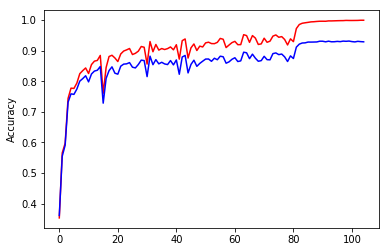

In [8]:
plt.plot(trains,'r')
plt.plot(evals,'b')
plt.ylabel('Accuracy')
plt.show()

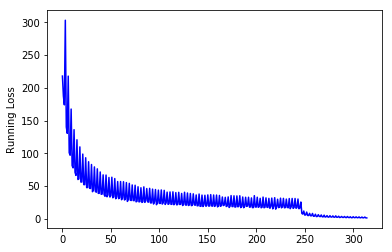

In [9]:
plt.plot(losses,'b')
plt.ylabel('Running Loss')
plt.show()